Librerias

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

import requests
import unidecode
import datetime
import dateutil
import subprocess
import sys
import json
import tempfile
import os

### importacion y limpieza de datos covid19 para Colombia 

In [6]:
# Input data files are available in the "../input/" directory.
INPUT_DIR = './'
if os.path.split(os.path.abspath('.'))[-1] == 'src':
    INPUT_DIR = '../input'
# Any results you write to the current directory are saved as output.
OUTPUT_DIR = './'
if os.path.split(os.path.abspath('.'))[-1] == 'src':
    OUTPUT_DIR = '../output'

In [7]:
# Official Daily Report Until Now
URL_DATASET = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD'
# Official Daily Samples Processed
URL_SAMPLES_PROCESSED = 'https://e.infogram.com/api/live/flex/638d656c-c77b-4326-97d3-e50cb410c6ab/8188140c-8352-4994-85e3-2100a4dbd9db?'
# Official Google Mobility
URL_GOOGLE_MOBILITY='https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

#### Datos Casos Reportados Covid19

In [111]:
# Official Daily Report Until Now
with requests.get(URL_DATASET) as official_dataset:
    open(os.path.join(INPUT_DIR, 'covid19co_official.csv'), 'wb').write(official_dataset.content)
covid19co = pd.read_csv(os.path.join(INPUT_DIR, 'covid19co_official.csv'))
covid19co.shape

(7285, 16)

In [112]:
covid19co.sample(n=5)

,ID de caso,Fecha de notificación,Codigo DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,País de procedencia,FIS,Fecha de muerte,Fecha diagnostico,Fecha recuperado,fecha reporte web
3652,3653,2020-04-13T00:00:00.000,76001,Cali,Valle del Cauca,Casa,26,M,En estudio,Leve,Colombia,2020-04-09T00:00:00.000,- -,2020-04-19T00:00:00.000,- -,2020-04-19T00:00:00.000
3236,3237,2020-04-07T00:00:00.000,66001,Pereira,Risaralda,Recuperado,78,M,Importado,Leve,Estados Unidos de América,2020-03-18T00:00:00.000,- -,2020-04-17T00:00:00.000,2020-04-09T00:00:00.000,2020-04-17T00:00:00.000
3954,3955,2020-04-13T00:00:00.000,25754,Soacha,Cundinamarca,Casa,34,F,En estudio,Leve,Colombia,2020-04-06T00:00:00.000,- -,2020-04-20T00:00:00.000,- -,2020-04-20T00:00:00.000
6098,6099,2020-04-26T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,61,M,En estudio,Leve,Colombia,2020-04-26T00:00:00.000,- -,2020-04-29T00:00:00.000,- -,2020-04-29T00:00:00.000
5041,5042,2020-04-19T00:00:00.000,66001,Pereira,Risaralda,Casa,30,M,En estudio,Leve,Colombia,2020-04-19T00:00:00.000,- -,2020-04-25T00:00:00.000,- -,2020-04-25T00:00:00.000


Columns Covid-19 Colombia

In [113]:
covid19co.columns

Index(['ID de caso', 'Fecha de notificación', 'Codigo DIVIPOLA',
       'Ciudad de ubicación', 'Departamento o Distrito ', 'atención', 'Edad',
       'Sexo', 'Tipo', 'Estado', 'País de procedencia', 'FIS',
       'Fecha de muerte', 'Fecha diagnostico', 'Fecha recuperado',
       'fecha reporte web'],
      dtype='object')

In [114]:
# Remove Accents and Uppercase
covid19co.columns = [unidecode.unidecode(value).upper() for value in covid19co.columns]
# Fill NaN Values
if covid19co.isna().sum().sum() > 0:
    covid19co.fillna(value='-', inplace=True)

In [115]:
col_clean=['ATENCION', 'SEXO', 'TIPO', 'ESTADO','DEPARTAMENTO O DISTRITO ']
for col_clean in col_clean:
    covid19co[col_clean]=covid19co[col_clean].str.title()

In [116]:
# Setup Date Format
date_columns = list(filter(lambda value: value.find('FECHA') != -1 or value.find('FIS') != -1, covid19co.columns))
#print(date_columns)
def setup_date(value):
    #print('date:', value)
    try:
        value = value.split('T')[0].split('-')
        if len(value) == 3:
            value = value[2] + '/' + value[1] + '/' + value[0]
        else:
            value = '-'
    except IndexError:
        value = '-'
    if len(value) != 10 and len(value) != 1:
        value = '-'
    return value
# For each date column
for date_column in date_columns:
    covid19co[date_column] = covid19co[date_column].transform(lambda value: setup_date(value))
# Show dataframe
covid19co.sample(n=5)

,ID DE CASO,FECHA DE NOTIFICACION,CODIGO DIVIPOLA,CIUDAD DE UBICACION,DEPARTAMENTO O DISTRITO,ATENCION,EDAD,SEXO,TIPO,ESTADO,PAIS DE PROCEDENCIA,FIS,FECHA DE MUERTE,FECHA DIAGNOSTICO,FECHA RECUPERADO,FECHA REPORTE WEB
2286,2287,03/04/2020,11001,Bogotá D.C.,Bogotá D.C.,Casa,44,F,En Estudio,Leve,Colombia,31/03/2020,-,10/04/2020,-,10/04/2020
2916,2917,05/04/2020,11001,Bogotá D.C.,Bogotá D.C.,Casa,65,M,En Estudio,Leve,Colombia,05/04/2020,-,14/04/2020,-,14/04/2020
3080,3081,13/04/2020,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,23,F,En Estudio,Leve,Colombia,10/04/2020,-,15/04/2020,26/04/2020,15/04/2020
4012,4013,18/04/2020,25126,Cajicá,Cundinamarca,Casa,25,F,En Estudio,Leve,Colombia,16/04/2020,-,21/04/2020,-,21/04/2020
2013,2014,29/03/2020,25175,Chía,Cundinamarca,Recuperado,56,M,En Estudio,Leve,Colombia,22/03/2020,-,08/04/2020,24/04/2020,08/04/2020


In [550]:
delta=[(datetime.datetime.strptime(covid19co['FECHA DIAGNOSTICO'][i], '%d/%m/%Y')-datetime.datetime.strptime(covid19co['FIS'][i], '%d/%m/%Y')).days for i in range (len(covid19co['FECHA DE NOTIFICACION'])) if covid19co['FIS'][i] != '-']
df = pd.DataFrame(delta)
df.describe()

,0
count,6474.000000
mean,11.599475
std,6.718208
min,0.000000
25%,7.000000
50%,10.000000
75%,15.000000
max,53.000000


In [117]:
covid19co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID DE CASO                7285 non-null   int64 
 1   FECHA DE NOTIFICACION     7285 non-null   object
 2   CODIGO DIVIPOLA           7285 non-null   int64 
 3   CIUDAD DE UBICACION       7285 non-null   object
 4   DEPARTAMENTO O DISTRITO   7285 non-null   object
 5   ATENCION                  7285 non-null   object
 6   EDAD                      7285 non-null   int64 
 7   SEXO                      7285 non-null   object
 8   TIPO                      7285 non-null   object
 9   ESTADO                    7285 non-null   object
 10  PAIS DE PROCEDENCIA       7285 non-null   object
 11  FIS                       7285 non-null   object
 12  FECHA DE MUERTE           7285 non-null   object
 13  FECHA DIAGNOSTICO         7285 non-null   object
 14  FECHA RECUPERADO        

In [118]:
# Save dataframe
covid19co.to_csv(os.path.join(OUTPUT_DIR, 'covid19co.csv'), index=False)

#### Datos muestras procesadas diariamente

In [119]:
# Official Samples Processed Until Now
with requests.get(URL_SAMPLES_PROCESSED) as official_dataset:
    with open(os.path.join(INPUT_DIR, 'covid19co_samples_processed_official.json'), 'w') as json_file:
        json_data = official_dataset.json()
        del json_data['refreshed']
        json.dump(json_data, json_file, ensure_ascii=False, indent=4)

In [120]:
# Open Official Samples Processed
with open(os.path.join(INPUT_DIR, 'covid19co_samples_processed_official.json')) as official_dataset:
    official_dataset = json.load(official_dataset)
# Official Samples Processed
official_dataset = official_dataset['data'][0]
covid19co_samples_processed = pd.DataFrame(columns=official_dataset[0], data=official_dataset[1:])
# Total Daily Report
covid19co_samples_processed.shape

(60, 2)

In [121]:
covid19co_samples_processed.head()

,Fecha,Muestras procesadas por corte
0,Acumulado Feb,601
1,5/3/20,636
2,6/3/2020 (Día 1),739
3,7/3/2020,810
4,8/3/2020,813


In [122]:
# Update Name Columns
# Remove Accents and Uppercase
covid19co_samples_processed.columns = [unidecode.unidecode(value).upper() for value in covid19co_samples_processed.columns]

In [123]:
# Setup Date Format
def setup_date_samples(value):
    #print('date:', value)
    try:
        value = value.split(' ')
        value = value[0].split('/')
        #print(len(value))
        if len(value) == 3:
            # Day
            if len(value[0]) == 1:
                value[0] = '0' + value[0]
            # Month
            if len(value[1]) == 1:
                value[1] = '0' + value[1]
            # Year
            if len(value[2]) == 2:
                value[2] = value[2] + '20'
            # Date
            value = value[0] + '/' + value[1] + '/' + value[2]
        else:
            value = '-'
    except IndexError:
        value = '-'
    #print('VALUE:', value)
    if len(value) != 10 and len(value) != 1:
        value = '-'
    return value
# Setup Date Format
covid19co_samples_processed['FECHA'] = covid19co_samples_processed['FECHA'].transform(lambda value: setup_date_samples(value))
# Show dataframe
covid19co_samples_processed.head()

,FECHA,MUESTRAS PROCESADAS POR CORTE
0,-,601
1,05/03/2020,636
2,06/03/2020,739
3,07/03/2020,810
4,08/03/2020,813


In [124]:
# Save dataframe
covid19co_samples_processed.to_csv(os.path.join(OUTPUT_DIR, 'covid19co_samples_processed.csv'), index=False)

#### Datos movilidad Colombia

In [8]:
# Official Daily Report Until Now
with requests.get(URL_GOOGLE_MOBILITY) as official_dataset:
    open(os.path.join(INPUT_DIR, 'google_mobility_official.csv'), 'wb').write(official_dataset.content)
google_mobility = pd.read_csv(os.path.join(INPUT_DIR, 'google_mobility_official.csv'))
google_mobility.shape

/home/nicolasbb/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(284489, 11)

In [306]:
google_mobility.sample(n=5)

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
101864,US,United States,California,San Francisco County,2020-03-21,-73.0,-22.0,-38.0,-65.0,-49.0,20.0
232796,US,United States,South Carolina,Florence County,2020-03-05,4.0,-2.0,NaN,8.0,-1.0,3.0
221925,US,United States,Oklahoma,Muskogee County,2020-03-13,3.0,10.0,-58.0,13.0,-4.0,3.0
134559,US,United States,Indiana,Harrison County,2020-04-11,-40.0,NaN,NaN,NaN,-30.0,NaN
166902,US,United States,Michigan,Emmet County,2020-04-22,-48.0,-20.0,NaN,NaN,-55.0,NaN


In [9]:
google_mobility_co = google_mobility[google_mobility['country_region'] == 'Colombia']

In [10]:
# Setup Date Format
def setup_date_samples(value):
    #print('date:', value)
    try:
        value = value.split('-')
        #print(len(value))
        if len(value) == 3:
            # Date
            value = value[2] + '/' + value[1] + '/' + value[0]
        else:
            value = '-'
    except IndexError:
        value = '-'
    #print('VALUE:', value)
    if len(value) != 10 and len(value) != 1:
        value = '-'
    return value
# Setup Date Format
google_mobility_co['date'] = google_mobility_co['date'].transform(lambda value: setup_date_samples(value))
# Show dataframe
google_mobility_co.sample(n=5)

/home/nicolasbb/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
14155,CO,Colombia,Amazonas Department,NaN,25/04/2020,NaN,NaN,-80.0,NaN,-40.0,NaN
14185,CO,Colombia,Antioquia,NaN,14/03/2020,-3.0,12.0,-7.0,-3.0,9.0,1.0
14219,CO,Colombia,Antioquia,NaN,17/04/2020,-78.0,-50.0,-68.0,-78.0,-68.0,35.0
14847,CO,Colombia,Cauca,NaN,28/03/2020,-80.0,-60.0,-69.0,-80.0,-58.0,27.0
15419,CO,Colombia,Magdalena,NaN,24/03/2020,-73.0,-56.0,-73.0,-78.0,-55.0,21.0


In [11]:
del google_mobility_co['country_region_code']
del google_mobility_co['country_region']
del google_mobility_co['sub_region_2']

In [13]:
google_mobility_co.sample(n=5)

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
14860,Cauca,10/04/2020,-84.0,-73.0,-78.0,-76.0,-76.0,34.0
15526,Narino,16/02/2020,-5.0,-1.0,-16.0,-21.0,1.0,4.0
15821,Risaralda,23/02/2020,-9.0,-5.0,-7.0,-4.0,0.0,2.0
15427,Magdalena,01/04/2020,-76.0,-55.0,-75.0,-85.0,-65.0,24.0
14484,Bolivar,25/03/2020,-83.0,-67.0,-83.0,-86.0,-73.0,29.0


In [311]:
# Save dataframe
google_mobility_co.to_csv(os.path.join(OUTPUT_DIR, 'google_mobility_co_processed.csv'), index=False)

### Exploratory Data Analisys

#### Tipo de casos Nacionales

Se obtiene la grafica de los tipos de casos a nivel nacional

In [132]:
# Time line cases reported [date, cases, accum_cases]
covid19co_time = pd.DataFrame(columns=['fecha', 'Importado', 'Relacionado','En Estudio', 'S.D.','Total','Acumulados'])
covid19co_time['fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-06', end=datetime.date.today().isoformat(), freq='D')]

In [133]:
# Total Cases Reported By Date
def get_total_cases_by_dates(dfreport):
    total_cases_by_date = {}
    # Group by 'FECHA REPORTE WEB'
    group_by_date = dfreport.groupby(['FECHA REPORTE WEB'], sort=False)
    # For each date
    for date_report in group_by_date.groups.keys():
        total_cases_by_date[date_report] = group_by_date.get_group(date_report)['ID DE CASO'].count()
    # Return
    return total_cases_by_date
# Total cases reported by date
total_cases_by_date = get_total_cases_by_dates(covid19co)

# Update Total Cases Reported by Date
covid19co_time['Total'] = covid19co_time['fecha'].transform(lambda date: total_cases_by_date[date] if date in total_cases_by_date else 0)

# Update Accumulative Sum Cases Reported by Date
covid19co_time['Acumulados'] = covid19co_time['Total'].cumsum()

In [134]:
# Total Cases Reported By Date
def get_total_cases_by_date(dfreport,columna,feature):
    total_cases_by_date = {}
    # Group by 'FECHA REPORTE WEB'
    group_by_date = dfreport[dfreport[columna]==feature].groupby(['FECHA REPORTE WEB'], sort=False)
    # For each date
    for date_report in group_by_date.groups.keys():
        total_cases_by_date[date_report] = group_by_date.get_group(date_report)['ID DE CASO'].count()
    # Return
    return total_cases_by_date


In [135]:
for tipo in covid19co['TIPO'].unique():
    total_cases_by_date = get_total_cases_by_date(covid19co,'TIPO',tipo)      
    covid19co_time[tipo] = covid19co_time['fecha'].transform(lambda date: total_cases_by_date[date] if date in total_cases_by_date else 0)

In [136]:
# Drop if doesn't have cases
covid19co_time=covid19co_time[covid19co_time['Total']!=0]
covid19co_time.sample(n=5)

,fecha,Importado,Relacionado,En Estudio,S.D.,Total,Acumulados
13,19/03/2020,18,8,0,NaN,26,130
25,31/03/2020,44,47,16,NaN,107,905
34,09/04/2020,15,77,77,NaN,169,2223
18,24/03/2020,57,45,3,NaN,105,419
31,06/04/2020,8,29,57,NaN,94,1579


In [137]:
ImportadoBars = [i / j * 100 for i,j in zip(covid19co_time['Importado'], covid19co_time['Total'])  ]
RelacionadoBars = [i / j * 100 for i,j in zip(covid19co_time['Relacionado'], covid19co_time['Total']) ]
En_EstudioBars = [i / j * 100 for i,j in zip(covid19co_time['En Estudio'], covid19co_time['Total']) ]
SDBars = [i / j * 100 for i,j in zip(covid19co_time['S.D.'], covid19co_time['Total']) ]

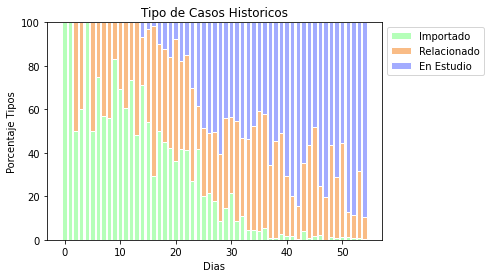

In [565]:
fig, ax = plt.subplots()
# plot
barWidth = 0.8
names = tuple(list(covid19co_time['fecha']))
r=[i for i in range (len(names))]
# Create ImportadoBars
plt.bar(r, ImportadoBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='Importado')
# Create RelacionadoBars Bars
plt.bar(r, RelacionadoBars, bottom=ImportadoBars, color='#f9bc86', edgecolor='white', width=barWidth, label='Relacionado')
# Create En_EstudioBars Bars
plt.bar(r, En_EstudioBars, bottom=[i+j for i,j in zip(ImportadoBars, RelacionadoBars)], color='#a3acff', edgecolor='white', width=barWidth, label='En Estudio')
# Create En_EstudioBars Bars
#plt.bar(r, SDBars, bottom=[i+j+k for i,j,k in zip(ImportadoBars, RelacionadoBars,En_EstudioBars)], color='#e377c2', edgecolor='white', width=barWidth, label='S.D.')

# Custom x axis
plt.xlabel("Dias")

plt.ylabel("Porcentaje Tipos")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.title('Tipo de Casos Historicos')
# Show graphic
plt.show()

In [567]:
covid19co['ATENCION'].unique()

array(['Recuperado', 'Casa', 'Fallecido', 'Hospital Uci', 'Hospital', '-'],
      dtype=object)

In [568]:
# Time line cases reported [date, cases, accum_cases]
covid19co_time_h = pd.DataFrame(columns=['fecha', 'Hospital Uci', 'Hospital'])
covid19co_time_h['fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-06', end=datetime.date.today().isoformat(), freq='D')]

In [570]:
def get_total_cases_by_date(dfreport,columna,feature):
    total_cases_by_date = {}
    # Group by 'FECHA REPORTE WEB'
    group_by_date = dfreport[dfreport[columna]==feature].groupby(['FECHA REPORTE WEB'], sort=False)
    # For each date
    for date_report in group_by_date.groups.keys():
        total_cases_by_date[date_report] = group_by_date.get_group(date_report)['ID DE CASO'].count()
    # Return
    return total_cases_by_date

In [571]:
H=['Hospital Uci', 'Hospital']
for h in H:
    total_cases_by_date = get_total_cases_by_date(covid19co,'ATENCION',h)      
    covid19co_time_h[h] = covid19co_time['fecha'].transform(lambda date: total_cases_by_date[date] if date in total_cases_by_date else 0)

In [573]:
covid19co_time_h[0:12]

,fecha,Hospital Uci,Hospital
0,06/03/2020,0.0,0.0
1,07/03/2020,NaN,NaN
2,08/03/2020,NaN,NaN
3,09/03/2020,0.0,0.0
4,10/03/2020,NaN,NaN
5,11/03/2020,0.0,0.0
6,12/03/2020,0.0,0.0
7,13/03/2020,0.0,0.0
8,14/03/2020,0.0,0.0
9,15/03/2020,0.0,0.0


In [575]:
covid19co_time_h=covid19co_time_h[4:56].set_index('fecha')

#### Personal de salud

Se realiza un analisis del personal de salud en Colombia relacionado con los boletines en imagen que da en INS, por tal los datos deben agregarse de forma manual

In [578]:
# Time line cases reported [date, cases, accum_cases]
Personal_de_Salud = pd.DataFrame(columns=['Fecha','Casos'])
Personal_de_Salud['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-10', end='2020-04-30', freq='D')]

In [ ]:
# Time line cases reported [date, cases, accum_cases]
Personal_de_Salud = pd.DataFrame(columns=['Fecha'])
Personal_de_Salud['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [581]:
Personal_de_Salud['Casos'][0:3]=0
Personal_de_Salud['Casos'][3]=1
Personal_de_Salud['Casos'][4]=1
Personal_de_Salud['Casos'][5]=0
Personal_de_Salud['Casos'][6]=3
Personal_de_Salud['Casos'][7]=8
Personal_de_Salud['Casos'][8]=7
Personal_de_Salud['Casos'][9]=9
Personal_de_Salud['Casos'][10]=5
Personal_de_Salud['Casos'][11]=10
Personal_de_Salud['Casos'][12]=8
Personal_de_Salud['Casos'][13]=8
Personal_de_Salud['Casos'][14]=9
Personal_de_Salud['Casos'][15]=9
Personal_de_Salud['Casos'][16]=10
Personal_de_Salud['Casos'][17]=19
Personal_de_Salud['Casos'][18]=6
Personal_de_Salud['Casos'][19]=3
Personal_de_Salud['Casos'][20]=14
Personal_de_Salud['Casos'][21]=4
Personal_de_Salud['Casos'][22]=13
Personal_de_Salud['Casos'][23]=11
Personal_de_Salud['Casos'][24]=6
Personal_de_Salud['Casos'][25]=8
Personal_de_Salud['Casos'][26]=5
Personal_de_Salud['Casos'][27]=8
Personal_de_Salud['Casos'][28]=6
Personal_de_Salud['Casos'][29]=12
Personal_de_Salud['Casos'][30]=10
Personal_de_Salud['Casos'][31]=13
Personal_de_Salud['Casos'][32]=17
Personal_de_Salud['Casos'][33]=17
Personal_de_Salud['Casos'][34]=14
Personal_de_Salud['Casos'][35]=26
Personal_de_Salud['Casos'][36]=8
Personal_de_Salud['Casos'][37]=6
Personal_de_Salud['Casos'][38]=4
Personal_de_Salud['Casos'][39]=28
Personal_de_Salud['Casos'][40]=14
Personal_de_Salud['Casos'][41]=4
Personal_de_Salud['Casos'][42]=3
Personal_de_Salud['Casos'][43]=1
Personal_de_Salud['Casos'][44:53]=0


In [582]:
Personal_de_Salud=Personal_de_Salud.set_index('Fecha')

In [591]:
Personal_de_Salud[0:45].astype(str).astype(int).describe()

,Casos
count,45.000000
mean,8.177778
std,6.446595
min,0.000000
25%,4.000000
50%,8.000000
75%,11.000000
max,28.000000


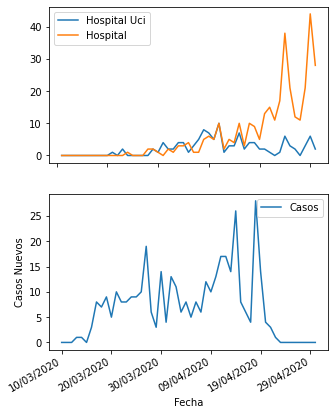

In [583]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,7))
covid19co_time_h.plot(ax=ax1) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Casos Nuevos")


Personal_de_Salud.plot(ax=ax2) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Casos Nuevos")
plt.show()

#### Reporte de muestras

Analisis de la cantidad de muestras procesadas respecto a los casos confirmados

In [139]:
# Time line cases reported [date, cases, accum_cases]
covid19co_muestras = pd.DataFrame(columns=['fecha', 'Casos', 'Muestras'])
covid19co_muestras['fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-4', end=datetime.date.today().isoformat(), freq='D')]

In [140]:
def get_total_cases_by_dates_diag(dfreport):
    total_cases_by_date = {}
    # Group by 'FECHA REPORTE WEB'
    group_by_date = dfreport.groupby(['FECHA DIAGNOSTICO'], sort=False)
    # For each date
    for date_report in group_by_date.groups.keys():
        total_cases_by_date[date_report] = group_by_date.get_group(date_report)['ID DE CASO'].count()
    # Return
    return total_cases_by_date
# Total cases reported by date
total_cases_by_date = get_total_cases_by_dates_diag(covid19co)

In [141]:
#Muestras diarias procesadas
covid19co_samples_processed['MUESTRAS PROCESADAS POR CORTE']=covid19co_samples_processed['MUESTRAS PROCESADAS POR CORTE'].astype(str).astype(int)
Primer=covid19co_samples_processed['MUESTRAS PROCESADAS POR CORTE'][0]
data=[covid19co_samples_processed['MUESTRAS PROCESADAS POR CORTE'][i]-covid19co_samples_processed['MUESTRAS PROCESADAS POR CORTE'][i-1] for i in range (1,len(covid19co_samples_processed['MUESTRAS PROCESADAS POR CORTE']))]
data.insert(0,Primer)
covid19co_samples_processed.insert(1,"Diarias",data)

In [142]:
# Update Total Cases Reported by Date
covid19co_muestras['Casos'] = covid19co_muestras['fecha'].transform(lambda date: total_cases_by_date[date] if date in total_cases_by_date else 0)
covid19co_muestras['Muestras']=covid19co_samples_processed["Diarias"]

In [143]:
CasosBars = [i / j * 100 for i,j in zip(covid19co_muestras['Casos'], covid19co_muestras['Muestras'])]
NoCasosBars = [(j-i) / j * 100 for i,j in zip(covid19co_muestras['Casos'], covid19co_muestras['Muestras'])]

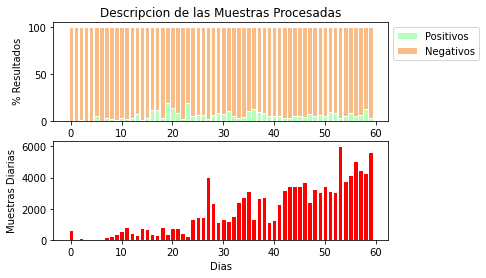

In [535]:
# plot
barWidth = 0.9
names = tuple(list(covid19co_muestras['fecha']))
r=[i for i in range (len(names))]
# Create ImportadoBars
plt.subplot(2,1,1)
plt.title("Descripcion de las Muestras Procesadas")
plt.bar(r, CasosBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='Positivos')
# Create RelacionadoBars Bars
plt.bar(r, NoCasosBars, bottom=CasosBars, color='#f9bc86', edgecolor='white', width=barWidth, label='Negativos')

# Custom x axis
#plt.xticks(r, names)
plt.xlabel("Dias")

plt.ylabel(" % Resultados")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# plot
barWidth = 0.9
names = tuple(list(covid19co_muestras['fecha']))
r=[i for i in range (len(names))]
plt.subplot(2,1,2)
# Create ImportadoBars
plt.bar(r, list(covid19co_muestras['Muestras']), color='red', edgecolor='white', width=barWidth)
# Custom x axis
#plt.xticks(r, names)
plt.xlabel("Dias")

#plt.xticks(r, names)
plt.ylabel("Muestras Diarias")



# Show graphic

plt.show()

In [146]:
covid19co_muestras.insert(3,"Porcentaje Positivos",CasosBars)

Analisis estadistico pruebas 

In [147]:
covid19co_muestras["Porcentaje Positivos"].describe()

count    60.000000
mean      6.082991
std       4.252181
min       0.000000
25%       3.382987
50%       5.389799
75%       8.203458
max      19.466667
Name: Porcentaje Positivos, dtype: float64

#### Crecimiento de los casos positivos

El analisis de crecimiento de casos se realiza por emdo de la curva de Aatishb

Crecimiento de casos
https://www.youtube.com/watch?v=54XLXg4fYsc&feature=youtu.be

In [402]:
# Time line cases reported [date, cases, accum_cases]
covid19co_progreso = pd.DataFrame(columns=['Fecha', 'Acumulados'])
covid19co_progreso['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-6', end=datetime.date.today().isoformat(), freq='7D')]

In [403]:
covid19co_progreso['Acumulados']=covid19co_progreso['Fecha'].transform(lambda date : list(covid19co_time['Acumulados'][covid19co_time.index[covid19co_time['fecha']==date]])[0])

In [404]:
Primer_1=covid19co_progreso['Acumulados'][0]
data_1=[covid19co_progreso['Acumulados'][i]-covid19co_progreso['Acumulados'][i-1] for i in range (1,len(covid19co_progreso['Acumulados']))]
data_1.insert(0,Primer_1)
covid19co_progreso.insert(1,"Nuevos Semana",data_1)

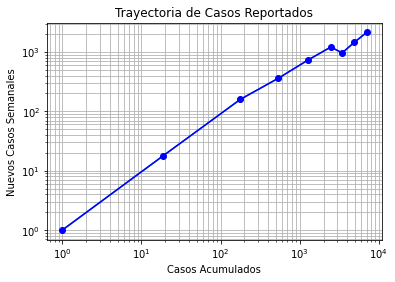

In [533]:
# plot

x=list(covid19co_progreso['Acumulados'])
y=list(covid19co_progreso['Nuevos Semana'])

plt.loglog(x, y)
plt.grid(True, which="both", ls="-")
plt.plot(x,y,'bo-')

# Custom  axis
plt.xlabel("Casos Acumulados")
plt.ylabel("Nuevos Casos Semanales")
plt.title('Trayectoria de Casos Reportados')

plt.show()

#### Casos historicos Acumulados

In [406]:
covid19co_progreso

,Fecha,Nuevos Semana,Acumulados
0,06/03/2020,1,1
1,13/03/2020,18,19
2,20/03/2020,159,178
3,27/03/2020,361,539
4,03/04/2020,727,1266
5,10/04/2020,1208,2474
6,17/04/2020,962,3436
7,24/04/2020,1443,4879
8,01/05/2020,2127,7006


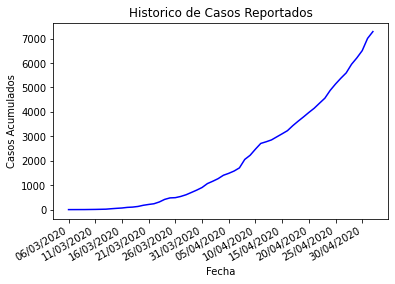

In [531]:
fig, ax = plt.subplots()
covid19co_time['Acumulados'].plot(ax=ax, color='blue')


names=[dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-6', end=datetime.date.today().isoformat(), freq='5D')]
n=len(names)
number=[i for i in range (1,len(names))]
plt.xticks(number,(0,)+tuple(names))
fig.autofmt_xdate()
ax.xaxis.set_major_locator(plt.MaxNLocator(n+1))

plt.xlabel("Fecha")
plt.ylabel("Casos Acumulados")
plt.title('Historico de Casos Reportados')
plt.show()

#### Analisis de movilidad en el caso Colombia

In [ ]:
#google_mobility_co=google_mobility_co.set_index('date')

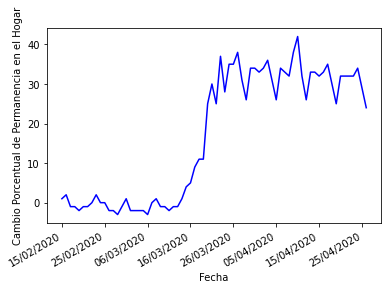

In [302]:
fig, ax = plt.subplots()
google_mobility_co['residential_percent_change_from_baseline'][0:72].plot(ax=ax, color='blue')
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual de Permanencia en el Hogar")
plt.show()


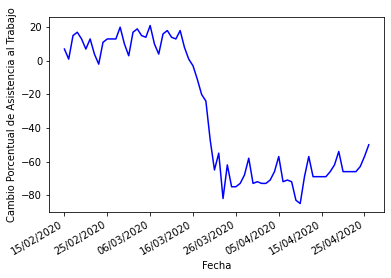

In [303]:
fig, ax = plt.subplots()
google_mobility_co['workplaces_percent_change_from_baseline'][0:72].plot(ax=ax, color='blue')
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual de Asistencia al Trabajo")
plt.show()

Para tener una mejor visualizacion se promedia los datos de forma semanal, de esta forma se suaviza la grafica

In [382]:
# Time line cases reported [date, cases, accum_cases]
Movility_Colombia_Prom = pd.DataFrame(columns=['Fecha'])
Movility_Colombia_Prom['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [383]:
Primer_2=list([google_mobility_co['workplaces_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_2=[[list([google_mobility_co['workplaces_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_2.insert(0,Primer_2)
data_2
Movility_Colombia_Prom.insert(1,'Cambio Porcentual Asistencia Trabajo',data_2)

In [ ]:
Movility_Colombia_Prom=Movility_Colombia_Prom.set_index('Fecha')

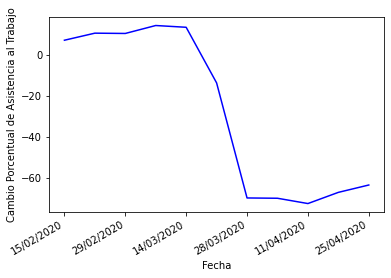

In [386]:
#Movility_Colombia_Prom=Movility_Colombia_Prom.set_index('Fecha')
fig, ax = plt.subplots()
Movility_Colombia_Prom['Cambio Porcentual Asistencia Trabajo'].plot(ax=ax, color='blue')
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual de Asistencia al Trabajo")
plt.show()

In [390]:
Movility_Colombia_Prom

,Cambio Porcentual Asistencia Trabajo,Cambio Porcentual Permanencia en Casa
Fecha,,
15/02/2020,7.000000,1.000000
22/02/2020,10.428571,-0.428571
29/02/2020,10.285714,-0.714286
07/03/2020,14.142857,-1.571429
14/03/2020,13.285714,-0.714286
21/03/2020,-13.714286,9.428571
28/03/2020,-69.571429,32.571429
04/04/2020,-69.714286,32.571429
11/04/2020,-72.285714,33.714286


In [388]:
Primer_3=list([google_mobility_co['residential_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_3=[[list([google_mobility_co['residential_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_3.insert(0,Primer_3)
data_3
Movility_Colombia_Prom.insert(1,'Cambio Porcentual Permanencia en Casa',data_3)

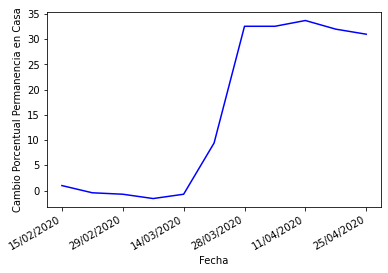

In [389]:
fig, ax = plt.subplots()
Movility_Colombia_Prom['Cambio Porcentual Permanencia en Casa'].plot(ax=ax, color='blue')
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual Permanencia en Casa")
plt.show()

In [409]:
Movility_Colombia_Pr = pd.DataFrame(columns=['Fecha','Casos Semana'])
Movility_Colombia_Pr['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [413]:
Movility_Colombia_Pr['Casos Semana'][0:3]=0
Movility_Colombia_Pr['Casos Semana'][3]=1
Movility_Colombia_Pr['Casos Semana'][4]=37
Movility_Colombia_Pr['Casos Semana'][5]=175
Movility_Colombia_Pr['Casos Semana'][6]=396
Movility_Colombia_Pr['Casos Semana'][7]=798
Movility_Colombia_Pr['Casos Semana'][8]=1303
Movility_Colombia_Pr['Casos Semana'][9]=910
Movility_Colombia_Pr['Casos Semana'][10]=1521

In [414]:
Movility_Colombia_Pr=Movility_Colombia_Pr.set_index('Fecha')

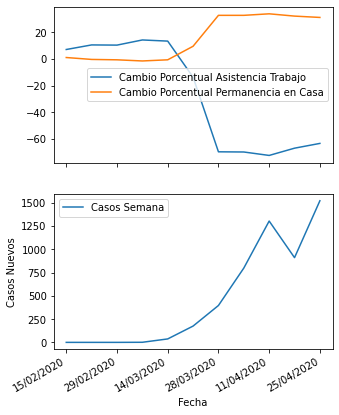

In [592]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,7))
Movility_Colombia_Prom.plot(ax=ax1) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual")


Movility_Colombia_Pr.plot(ax=ax2) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Casos Nuevos")
plt.show()

#### Regionales

Se realiza un analisis similar a las  principales ciudadesdel pais con mayor numero de infectados 

In [472]:
google_mobility_co['sub_region_1'].unique()

array([nan, 'Amazonas Department', 'Antioquia', 'Arauca', 'Atlantico',
       'Bogota', 'Bolivar', 'Boyaca', 'Caldas', 'Caquetá', 'Casanare',
       'Cauca', 'Cesar', 'Choco', 'Cordoba', 'Cundinamarca', 'Guaviare',
       'Huila', 'La Guajira', 'Magdalena', 'Meta', 'Narino',
       'North Santander', 'Putumayo', 'Quindio', 'Risaralda',
       'San Andrés and Providencia', 'Santander', 'Sucre', 'Tolima',
       'Valle del Cauca', 'Vichada'], dtype=object)

In [455]:
# Time line cases reported [date, cases, accum_cases]
covid19co_time_regional = pd.DataFrame(columns=['fecha'])
covid19co_time_regional['fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-06', end=datetime.date.today().isoformat(), freq='D')]

In [456]:
# Total Cases Reported By Date
def get_total_cases_by_date(dfreport,departamento):
    total_cases_by_date = {}
    # Group by 'FECHA REPORTE WEB'
    group_by_date = dfreport[dfreport['DEPARTAMENTO O DISTRITO ']==departamento].groupby(['FECHA REPORTE WEB'], sort=False)
    # For each date
    for date_report in group_by_date.groups.keys():
        total_cases_by_date[date_report] = group_by_date.get_group(date_report)['ID DE CASO'].count()
    # Return
    return total_cases_by_date


In [457]:
Departamentos=['Bogotá D.C.', 'Valle Del Cauca', 'Antioquia','Meta']
for dep in Departamentos:
    total_cases_by_date = get_total_cases_by_date(covid19co, dep)      
    covid19co_time_regional.insert(1,f'Casos_{dep}',covid19co_time_regional['fecha'].transform(lambda date: total_cases_by_date[date] if date in total_cases_by_date else 0))
    covid19co_time_regional.insert(1,f'Acumulados_{dep}', covid19co_time_regional[f'Casos_{dep}'].cumsum())
    

In [482]:
covid19co_progreso_regional = pd.DataFrame(columns=['Fecha'])
covid19co_progreso_regional['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-03-6', end=datetime.date.today().isoformat(), freq='7D')]

In [483]:
for dep in Departamentos:
    covid19co_progreso_regional.insert(1,f'Acumulados_{dep}',covid19co_progreso['Fecha'].transform(lambda date : list(covid19co_time_regional[f'Acumulados_{dep}'][covid19co_time_regional.index[covid19co_time_regional['fecha']==date]])[0]))
    Primer=covid19co_progreso_regional[f'Acumulados_{dep}'][0]
    data=[covid19co_progreso_regional[f'Acumulados_{dep}'][i]-covid19co_progreso_regional[f'Acumulados_{dep}'][i-1] for i in range (1,len(covid19co_progreso_regional[f'Acumulados_{dep}']))]
    data.insert(0,Primer)
    covid19co_progreso_regional.insert(1,f'Nuevos Semana {dep}',data)

In [484]:
covid19co_progreso_regional

,Fecha,Nuevos Semana Meta,Acumulados_Meta,Nuevos Semana Antioquia,Acumulados_Antioquia,Nuevos Semana Valle Del Cauca,Acumulados_Valle Del Cauca,Nuevos Semana Bogotá D.C.,Acumulados_Bogotá D.C.
0,06/03/2020,0,0,0,0,0,0,1,1
1,13/03/2020,1,1,4,4,3,3,5,6
2,20/03/2020,0,1,18,22,12,15,73,79
3,27/03/2020,7,8,38,60,59,74,138,217
4,03/04/2020,5,13,85,145,92,166,359,576
5,10/04/2020,4,17,101,246,248,414,525,1101
6,17/04/2020,29,46,79,325,172,586,273,1374
7,24/04/2020,116,162,122,447,189,775,677,2051
8,01/05/2020,313,475,28,475,205,980,722,2773


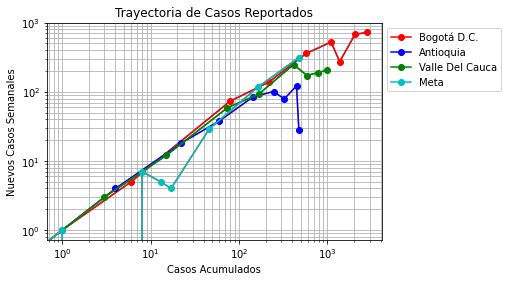

In [593]:
# plot

x1=list(covid19co_progreso_regional['Acumulados_Bogotá D.C.'])
y1=list(covid19co_progreso_regional['Nuevos Semana Bogotá D.C.'])

x2=list(covid19co_progreso_regional['Acumulados_Antioquia'])
y2=list(covid19co_progreso_regional['Nuevos Semana Antioquia'])

x3=list(covid19co_progreso_regional['Acumulados_Valle Del Cauca'])
y3=list(covid19co_progreso_regional['Nuevos Semana Valle Del Cauca'])

x4=list(covid19co_progreso_regional['Acumulados_Meta'])
y4=list(covid19co_progreso_regional['Nuevos Semana Meta'])

plt.loglog(x1, y1)
plt.plot(x1,y1,'ro-',label='Bogotá D.C.')

plt.loglog(x2, y2)
plt.plot(x2,y2,'bo-',label='Antioquia')

plt.loglog(x3, y3)
plt.plot(x3,y3,'go-',label='Valle Del Cauca')

plt.loglog(x4, y4)
plt.plot(x4,y4,'co-', label='Meta')

plt.grid(True, which="both", ls="-")

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
# Custom  axis
plt.xlabel("Casos Acumulados")
plt.ylabel("Nuevos Casos Semanales")
plt.title('Trayectoria de Casos Reportados')

plt.show()

In [471]:
# Time line cases reported [date, cases, accum_cases]
Movility_Colombia_Prom_Bog = pd.DataFrame(columns=['Fecha'])
Movility_Colombia_Prom_Bog['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [475]:
google_mobility_bog=google_mobility_co[google_mobility_co['sub_region_1']=='Bogota']

In [476]:
# Time line cases reported [date, cases, accum_cases]
Movility_Bog_Prom = pd.DataFrame(columns=['Fecha'])
Movility_Bog_Prom['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [477]:
Primer_2=list([google_mobility_bog['workplaces_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_2=[[list([google_mobility_bog['workplaces_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_2.insert(0,Primer_2)
data_2
Movility_Bog_Prom.insert(1,'Cambio Porcentual Asistencia Trabajo',data_2)

Primer_3=list([google_mobility_bog['residential_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_3=[[list([google_mobility_bog['residential_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_3.insert(0,Primer_3)
data_3
Movility_Bog_Prom.insert(1,'Cambio Porcentual Permanencia en Casa',data_3)

In [478]:
Movility_Bog_Pr = pd.DataFrame(columns=['Fecha','Casos Semana'])
Movility_Bog_Pr['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [486]:
Movility_Bog_Pr['Casos Semana'][0:3]=0
Movility_Bog_Pr['Casos Semana'][3]=1
Movility_Bog_Pr['Casos Semana'][4]=5
Movility_Bog_Pr['Casos Semana'][5]=73
Movility_Bog_Pr['Casos Semana'][6]=138
Movility_Bog_Pr['Casos Semana'][7]=359
Movility_Bog_Pr['Casos Semana'][8]=525
Movility_Bog_Pr['Casos Semana'][9]=273
Movility_Bog_Pr['Casos Semana'][10]=677

In [487]:
Movility_Bog_Prom=Movility_Bog_Prom.set_index('Fecha')
Movility_Bog_Pr=Movility_Bog_Pr.set_index('Fecha')

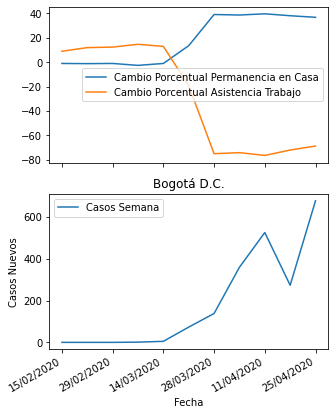

In [595]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,7))
plt.title('Bogotá D.C.')
Movility_Bog_Prom.plot(ax=ax1) 
fig.autofmt_xdate()

plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual")


Movility_Bog_Pr.plot(ax=ax2) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Casos Nuevos")
plt.show()

In [490]:
Movility_Bog_Prom

,Cambio Porcentual Permanencia en Casa,Cambio Porcentual Asistencia Trabajo
Fecha,,
15/02/2020,-1.000000,9.000000
22/02/2020,-1.142857,12.000000
29/02/2020,-1.000000,12.428571
07/03/2020,-2.571429,14.714286
14/03/2020,-1.000000,13.000000
21/03/2020,13.571429,-19.142857
28/03/2020,39.142857,-75.000000
04/04/2020,38.714286,-74.142857
11/04/2020,39.714286,-76.428571


In [497]:
# Time line cases reported [date, cases, accum_cases]
Movility_Colombia_Prom_Ant = pd.DataFrame(columns=['Fecha'])
Movility_Colombia_Prom_Ant['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [498]:
google_mobility_Ant=google_mobility_co[google_mobility_co['sub_region_1']=='Antioquia']

In [499]:
# Time line cases reported [date, cases, accum_cases]
Movility_Ant_Prom = pd.DataFrame(columns=['Fecha'])
Movility_Ant_Prom['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [500]:
Primer_2=list([google_mobility_Ant['workplaces_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_2=[[list([google_mobility_Ant['workplaces_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_2.insert(0,Primer_2)
data_2
Movility_Ant_Prom.insert(1,'Cambio Porcentual Asistencia Trabajo',data_2)

Primer_3=list([google_mobility_Ant['residential_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_3=[[list([google_mobility_Ant['residential_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_3.insert(0,Primer_3)
data_3
Movility_Ant_Prom.insert(1,'Cambio Porcentual Permanencia en Casa',data_3)

In [501]:
Movility_Ant_Pr = pd.DataFrame(columns=['Fecha','Casos Semana'])
Movility_Ant_Pr['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [502]:
Movility_Ant_Pr['Casos Semana'][0:3]=0
Movility_Ant_Pr['Casos Semana'][3]=0
Movility_Ant_Pr['Casos Semana'][4]=4
Movility_Ant_Pr['Casos Semana'][5]=18
Movility_Ant_Pr['Casos Semana'][6]=38
Movility_Ant_Pr['Casos Semana'][7]=85
Movility_Ant_Pr['Casos Semana'][8]=101
Movility_Ant_Pr['Casos Semana'][9]=79
Movility_Ant_Pr['Casos Semana'][10]=122

In [503]:
Movility_Ant_Prom=Movility_Ant_Prom.set_index('Fecha')
Movility_Ant_Pr=Movility_Ant_Pr.set_index('Fecha')

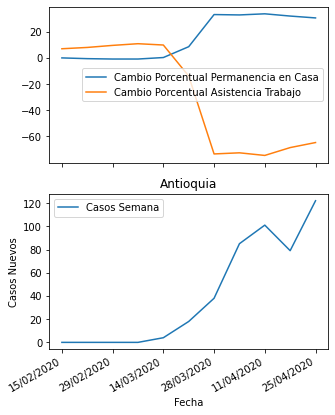

In [596]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,7))
Movility_Ant_Prom.plot(ax=ax1) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual")
plt.title('Antioquia')

Movility_Ant_Pr.plot(ax=ax2) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Casos Nuevos")
plt.show()

In [506]:
Movility_Ant_Prom

,Cambio Porcentual Permanencia en Casa,Cambio Porcentual Asistencia Trabajo
Fecha,,
15/02/2020,0.000000,7.000000
22/02/2020,-0.571429,8.000000
29/02/2020,-0.857143,9.571429
07/03/2020,-0.857143,10.857143
14/03/2020,0.285714,9.857143
21/03/2020,8.571429,-13.857143
28/03/2020,33.142857,-73.428571
04/04/2020,32.857143,-72.571429
11/04/2020,33.714286,-74.571429


In [507]:
# Time line cases reported [date, cases, accum_cases]
Movility_Colombia_Prom_VCauc = pd.DataFrame(columns=['Fecha'])
Movility_Colombia_Prom_VCauc['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [508]:
google_mobility_VCauc=google_mobility_co[google_mobility_co['sub_region_1']=='Valle del Cauca']

In [509]:
# Time line cases reported [date, cases, accum_cases]
Movility_VCauc_Prom = pd.DataFrame(columns=['Fecha'])
Movility_VCauc_Prom['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [510]:
Primer_2=list([google_mobility_VCauc['workplaces_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_2=[[list([google_mobility_VCauc['workplaces_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_2.insert(0,Primer_2)
data_2
Movility_VCauc_Prom.insert(1,'Cambio Porcentual Asistencia Trabajo',data_2)

Primer_3=list([google_mobility_VCauc['residential_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_3=[[list([google_mobility_VCauc['residential_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_3.insert(0,Primer_3)
data_3
Movility_VCauc_Prom.insert(1,'Cambio Porcentual Permanencia en Casa',data_3)

In [513]:
Movility_VCauc_Pr = pd.DataFrame(columns=['Fecha','Casos Semana'])
Movility_VCauc_Pr['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [514]:
Movility_VCauc_Pr['Casos Semana'][0:3]=0
Movility_VCauc_Pr['Casos Semana'][3]=0
Movility_VCauc_Pr['Casos Semana'][4]=3
Movility_VCauc_Pr['Casos Semana'][5]=12
Movility_VCauc_Pr['Casos Semana'][6]=59
Movility_VCauc_Pr['Casos Semana'][7]=92
Movility_VCauc_Pr['Casos Semana'][8]=248
Movility_VCauc_Pr['Casos Semana'][9]=172
Movility_VCauc_Pr['Casos Semana'][10]=189

In [517]:
Movility_VCauc_Prom=Movility_VCauc_Prom.set_index('Fecha')
Movility_VCauc_Pr=Movility_VCauc_Pr.set_index('Fecha')

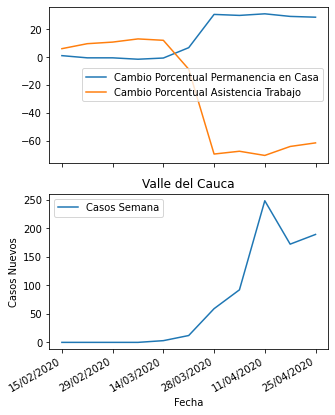

In [597]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,7))
Movility_VCauc_Prom.plot(ax=ax1) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual")

plt.title('Valle del Cauca')

Movility_VCauc_Pr.plot(ax=ax2) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Casos Nuevos")
plt.show()

In [520]:
Movility_VCauc_Prom

,Cambio Porcentual Permanencia en Casa,Cambio Porcentual Asistencia Trabajo
Fecha,,
15/02/2020,1.000000,6.000000
22/02/2020,-0.571429,9.571429
29/02/2020,-0.571429,10.714286
07/03/2020,-1.571429,13.000000
14/03/2020,-0.714286,12.000000
21/03/2020,6.714286,-8.714286
28/03/2020,30.571429,-69.571429
04/04/2020,29.857143,-67.571429
11/04/2020,31.000000,-70.571429


In [521]:
# Time line cases reported [date, cases, accum_cases]
Movility_Colombia_Prom_Meta = pd.DataFrame(columns=['Fecha'])
Movility_Colombia_Prom_Meta['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [522]:
google_mobility_Meta=google_mobility_co[google_mobility_co['sub_region_1']=='Meta']

In [523]:
# Time line cases reported [date, cases, accum_cases]
Movility_Meta_Prom = pd.DataFrame(columns=['Fecha'])
Movility_Meta_Prom['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [524]:
Primer_2=list([google_mobility_Meta['workplaces_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_2=[[list([google_mobility_Meta['workplaces_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_2.insert(0,Primer_2)
data_2
Movility_Meta_Prom.insert(1,'Cambio Porcentual Asistencia Trabajo',data_2)

Primer_3=list([google_mobility_Meta['residential_percent_change_from_baseline'][i:i+7] for i in range (0,70,7)][0])[0]
data_3=[[list([google_mobility_Meta['residential_percent_change_from_baseline'][i:i+7].cumsum() for i in range (0,70,7)][i]) for i in range (10)][i][6]/7 for i in range (10)]
data_3.insert(0,Primer_3)
data_3
Movility_Meta_Prom.insert(1,'Cambio Porcentual Permanencia en Casa',data_3)

In [525]:
Movility_Meta_Pr = pd.DataFrame(columns=['Fecha','Casos Semana'])
Movility_Meta_Pr['Fecha'] = [dti.strftime('%d/%m/%Y') for dti in pd.date_range(start='2020-02-15', end='2020-04-25', freq='7D')]

In [526]:
Movility_Meta_Pr['Casos Semana'][0:3]=0
Movility_Meta_Pr['Casos Semana'][3]=0
Movility_Meta_Pr['Casos Semana'][4]=1
Movility_Meta_Pr['Casos Semana'][5]=0
Movility_Meta_Pr['Casos Semana'][6]=7
Movility_Meta_Pr['Casos Semana'][7]=5
Movility_Meta_Pr['Casos Semana'][8]=4
Movility_Meta_Pr['Casos Semana'][9]=29
Movility_Meta_Pr['Casos Semana'][10]=116

In [527]:
Movility_Meta_Prom=Movility_Meta_Prom.set_index('Fecha')
Movility_Meta_Pr=Movility_Meta_Pr.set_index('Fecha')

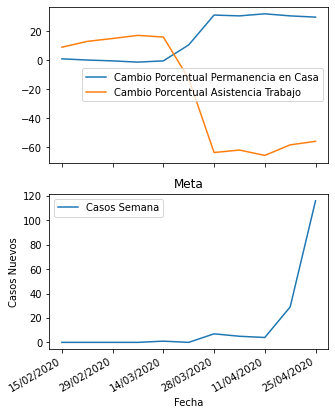

In [598]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,7))
Movility_Meta_Prom.plot(ax=ax1) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Cambio Porcentual")

plt.title('Meta')
Movility_Meta_Pr.plot(ax=ax2) 
fig.autofmt_xdate()
plt.xlabel("Fecha")
plt.ylabel("Casos Nuevos")
plt.show()

In [529]:
Movility_Meta_Prom

,Cambio Porcentual Permanencia en Casa,Cambio Porcentual Asistencia Trabajo
Fecha,,
15/02/2020,1.000000,9.000000
22/02/2020,0.142857,13.000000
29/02/2020,-0.428571,15.000000
07/03/2020,-1.285714,17.142857
14/03/2020,-0.428571,16.000000
21/03/2020,10.571429,-12.714286
28/03/2020,31.142857,-63.571429
04/04/2020,30.571429,-61.857143
11/04/2020,32.000000,-65.571429
